# Lab4 使用 Python 对 PostgreSQL 进行 SQL 操作

本节实验使用 Python 连接 PostgreSQL 数据库，并对 PostgreSQL 数据库进行简单的 DDL 与 DQL 操作，掌握 psycopg2 的基本语法、数据插入、单表查找及数据库约束等相关知识。

## 1. 使用 psycopg2 连接并操作 PostgreSQL，掌握基础语法

In [1]:
# 导入python与postgresql操作库
import psycopg2

连接数据库，host 和 port 不用修改，user="ecnu学号", password="ECNU学号", database="ecnu学号"  
获取 SQL 执行器 cursor，后续会使用 cursor 执行 SQL 并获取返回结果。

In [2]:
conn = psycopg2.connect(host="172.16.253.154", port="5432", user="ecnu10205501432", password="ECNU10205501432", database="ecnu10205501432")
autocommit = psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT
conn.set_isolation_level(autocommit)
cur = conn.cursor()

In [3]:
# 列出当前所在数据库的名字
sql = "select current_database();"
# 执行SQL
cur.execute(sql)
# SQL执行后，会将结果以元组的形式缓存在cursor中，使用下述语句输出
for tuple in cur.fetchall():
    print(tuple)

('ecnu10205501432',)


In [12]:
# 创建employee表
sql = 'CREATE TABLE EMPLOYEE(ID INT PRIMARY KEY, NAME TEXT, AGE INT, CITY CHAR(15), SALARY REAL);'
cur.execute(sql)
# sql = "DROP TABLE EMPLOYEE"
# cur.execute(sql)

In [13]:
# 列出当前数据库中的表，与在SQL Shell中操作完全不同
# SQL Shell将一些常见指令封装为快捷操作符"\c \d \l"等，但是使用psycopg2需要写出完整的SQL命令
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")

for tuple in cur.fetchall():
    print(tuple)

('employee',)


In [14]:
# 删除employee表的主键约束
sql = "ALTER TABLE EMPLOYEE DROP CONSTRAINT employee_pkey;"
cur.execute(sql)

查看约束的变化。目前没有找到比较方便使用的 SQL 语句，大家可以在终端中连接 PG 并查询，操作如下： 

<left>
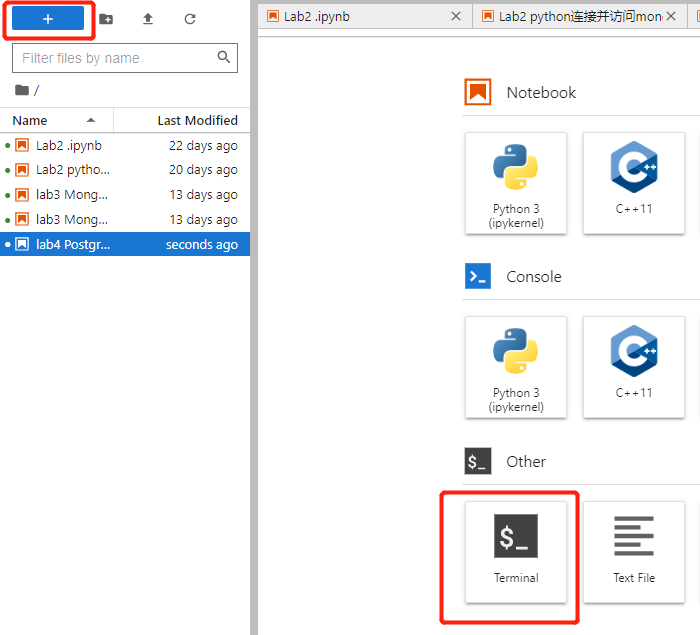
</left>

点击左上角 + 按钮，再点击 Terminal，进入下述界面，输入命令：
psql -h 172.16.253.154 -p 5432 -U ecnuxxxx -d ecnuxxxx

回车输入密码：ECNUxxx （xxxx是个人的学号）

<left>
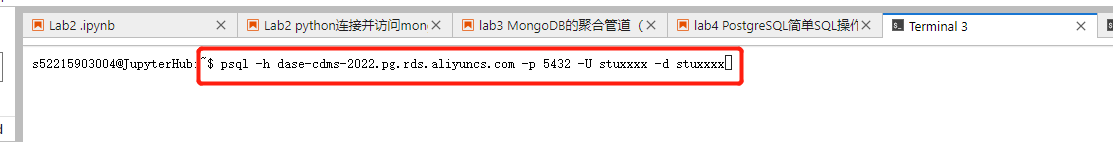
</left>

即连接进入自己的数据库中，可以进行操作，和 SQL Shell 的指令相同。

在终端中输入下述命令，查看 employee 表的约束信息：

`\d employee`

可以看到，employee 表的主键约束已经删除。 

除与此类似，其他简短的 sql 命令也可以在终端运行，及时返回结果，便于调试。

如果同学们有更好的方法显示表的约束信息，可以写在 lab 里，也可以在群里和大家分享一下。

In [15]:
# 在employee表的id属性创建主键约束
sql = "ALTER TABLE EMPLOYEE ADD CONSTRAINT employee_pkey PRIMARY KEY (id);"
cur.execute(sql)

在终端中输入`\d employee`查询约束信息，可以看到主键约束已经存在。

In [16]:
# 插入一条记录，%s为占位符，在执行插入语句时填入相应的值
sql = "insert into employee (id, name, age, city, salary) values (%s, %s, %s, %s ,%s)"

cur.execute(sql, (1, '张山', 25, '上海', 10000))

In [17]:
# 输出employee表中全部的元组
sql = "select * from employee"
cur.execute(sql)

for tuple in cur.fetchall():
    print(tuple)

(1, '张山', 25, '上海             ', 10000.0)


In [18]:
# 批量插入多条数据
# 构造一个二维列表
values = [[2, '李思', 23, '北京', 12000],
          [3, '王武', 28, '深圳', 16000],
          [4, '赵柳', 22, '广州', 8000]]
sql = "insert into employee (id, name, age, city, salary) values (%s, %s, %s, %s ,%s)"

cur.executemany(sql, values)

In [19]:
# 输出employee表中全部的元组
sql = "select * from employee"
cur.execute(sql)

for tuple in cur.fetchall():
    print(tuple)

(1, '张山', 25, '上海             ', 10000.0)
(2, '李思', 23, '北京             ', 12000.0)
(3, '王武', 28, '深圳             ', 16000.0)
(4, '赵柳', 22, '广州             ', 8000.0)


In [20]:
# 查询收入在10000以上的员工姓名与年龄
sql = "select name, age  from employee where salary > %s"
# 注意10000后面要加一个","
cur.execute(sql, (10000,))

for tuple in cur.fetchall():
    print(tuple)

('李思', 23)
('王武', 28)


In [21]:
# 删除employee全部的数据
sql1 = "Delete from employee"
sql2 = "DROP TABLE employee"
cur.execute(sql1)
cur.execute(sql2)


## 2. DDL、DQL 练习

考虑一个零件销售供应商数据库，里面包含四张数据表：S（供应商）、P（零件）、J（工厂）、SPJ（工厂订购供应商零件的信息），每张数据表的初始化属性与约束如下： 

S: SNO (CHAR(2)), SNAME (CHAR(6)), STATUS (CHAR(2)), CITY (CHAR(4))      SNO 为主键 

P: PNO (CHAR(2)), PNAME (CHAR(6)), COLOR (CHAR(2)), WEIGHT (INT)         PNO 为主键 

J: JNO (CHAR(2)), JNAME (CHAR(8)), CITY (CHAR(4))                        JNO 为主键 

SPJ: SNO char(2), PNO char(2), JNO char(2)                               (SNO,PNO,JNO) 为主键 

### 1. 创建表与约束

在创建表前，最基础的事情是确定属性及属性的类型，除了前面的讲解中出现的与下方列出的常用数据类型外，PostgreSQL 提供了非常丰富的数据类型：http://www.postgres.cn/docs/14/datatype.html 

|     类型     |                描述           |
|     ----     |    ---------------------------   |
|     TEXT     |    字符类型，变长，无长度限制    |
|   CHAR(NUM)  |    字符类型，定长，字符长度为NUM |
| VARCHAR(NUM) |    字符类型，变长， 字符最长限制为NUM  |
|     BOOL     |    布尔类型  |
|     REAL     |    浮点类型（单精度） |
|    float8    |    浮点类型（双精度） |
|      INT     |    整型 |


除了前面的讲解中出现的主键约束、非空约束与唯一约束外，数据库还包含外键约束和检查约束，简介如下：

|     约束     |                描述            |
|     ----     |     ---------------------------   |
|   主键约束   |     NOT NULL 和 UNIQUE 的结合。确保某列（或两个列多个列的结合）有唯一标识，有助于更容易更快速地找到表中的一个特定的记录。   |
|   唯一约束   |     在一列中或者一组列中保存的数据在表中所有行间是唯一的 |
|   非空约束   |     指定一个列中不会有空值        |
|   外键约束   |     保证一个表中的数据匹配另一个表中的值的参照完整性 |
|   检查约束   |     指定一个某个列的值必须要满足一个布尔表达式 |


在创建表的同时添加约束的语法细节可以参考文档：http://www.postgres.cn/docs/14/ddl-constraints.html 

请同学们完成下述创建表的练习：

#### 练习一：根据上述表的属性和约束信息，完成表的创建：

In [47]:
# 填写代码，可以在多个cell中完成：
sql = 'CREATE TABLE S(SNO CHAR(2) PRIMARY KEY, SNAME CHAR(6), STATUS CHAR(2), CITY CHAR(4));'
cur.execute(sql)

In [48]:
sql = 'CREATE TABLE P(PNO CHAR(2) PRIMARY KEY, PNAME CHAR(6), COLOR CHAR(2), WEIGHT INT);'
cur.execute(sql)

In [49]:
sql = 'CREATE TABLE J(JNO CHAR(2) PRIMARY KEY, JNAME CHAR(8), CITY CHAR(4));'
cur.execute(sql)

In [50]:
sql = 'CREATE TABLE SPJ (SNO char(2),PNO char(2),JNO char(2),PRIMARY KEY (SNO, PNO, JNO));'
cur.execute(sql)

### 2. 利用 DDL 修改表信息

如果我们在创建表后，发现表信息需要修改或者需要修改约束条件，那么就需要利用DDL语句修改表。

常见的修改表语句如下所示：

|     操作        |                语法格式            |
|     ----        |     ---------------------------   |
|   增加\删除列   |   ALTER TABLE tablename ADD COLUMN colname coltype <br> ALTER TABLE tablename DROP COLUMN colname |
|   增加\删除约束  |   xxxxx ADD CONSTRAINT constraint_name constraint_type (col_name)(主键\UNIQUE约束) <br> xxxx ADD FOREIGN KEY (colname) REFERENCES tablename(外键约束) <br> xxxxALTER COLUMN colname SET NOT NULL(非空约束) <br> xxxxx DROP CONSTRAINT constraint_name(删除约束) <br> （注意NOT NULL约束的特殊性） |
|   修改列数据类型   |     xxxxx ALTER COLUMN colname TYPE coltype    |
|   重命名列\表   |    xxxxx RENAME COLUMN colname TO new_colname <br> ALTER TABLE tablename RENAME TO new_tablename |


需要注意的是，以上修改操作并非一定成功。例如，删除某列时如果该列存在外加键约束并被其他表引用，则无法删除该列， 
需要在语句末尾添加 "CASCADE" 关键字，表示尽可能地级联删除与该列存在关联的数据。

更多细节与实现方法，请参考官方文档： http://www.postgres.cn/docs/14/ddl-alter.html 

在修改过程中可通过在终端输入`\d 表名`查看修改后的表信息。

请同学们完成下述修改表的练习：

#### 练习二：为 SPJ 表中 SNO, PNO, JNO 分别添加外键约束

In [51]:
# 填写代码，可在多个cell中完成
sql = "ALTER TABLE SPJ ADD FOREIGN KEY (SNO) REFERENCES S;"
cur.execute(sql)
# 在终端中输入"\d spj" 可查看约束信息

In [52]:
sql = "ALTER TABLE SPJ ADD FOREIGN KEY (PNO) REFERENCES P;"
cur.execute(sql)

In [53]:
sql = "ALTER TABLE SPJ ADD FOREIGN KEY (JNO) REFERENCES J;"
cur.execute(sql)

#### 练习三：为 SPJ 增加属性列 QTY 数据类型 INT，表示工厂向供应商购买某种零件的数量，并添加检查约束 (QTY > 0 且分非空)

In [54]:
# 填写代码，可在多个cell中完成
sql = "ALTER TABLE SPJ ADD COLUMN QTY INT;"
cur.execute(sql)

In [55]:
sql = "ALTER TABLE SPJ ADD CONSTRAINT check_qty CHECK (QTY > 0 AND QTY IS NOT NULL);"
cur.execute(sql)

#### 练习四：为 P 表 WEIGHT 属性添加 NOT NULL 约束。

In [56]:
# 填写代码
sql = "ALTER TABLE P ALTER COLUMN WEIGHT SET NOT NULL;"
cur.execute(sql)

### 3. 插入数据

#### 练习五：执行下述 SQL，插入初始数据

```SQL
insert into S(Sno,Sname,Status,City)
values
('S1','精益','20','天津'),
('S2','盛锡','10','北京'),
('S3','东方红','30','北京'),
('S4','丰泰盛','20','天津'),
('S5','为民','30','上海');

insert into P(Pno,Pname,color,weight)
values
('P1','螺母','红',12),
('P2','螺栓','绿',17),
('P3','螺丝刀','蓝',14),
('P4','螺丝刀','红',14),
('P5','凸轮','蓝',40),
('P6','齿轮','红',30);

insert into J(Jno,Jname,CITY)
values
('J1','三建','北京'),
('J2','一汽','长春'),
('J3','弹簧厂','天津'),
('J4','造船厂','天津'),
('J5','机车厂','唐山'),
('J6','无线电厂','常州'),
('J7','半导体厂','南京');

insert into SPJ(Sno,Pno,Jno,QTY)
values
('S1','P1','J1',200),
('S1','P1','J3',100),
('S1','P1','J4',700),
('S1','P2','J2',100),
('S2','P3','J1',400),
('S2','P3','J2',200),
('S2','P3','J4',500),
('S2','P3','J5',400),
('S2','P5','J1',400),
('S2','P5','J2',100),
('S3','P1','J1',200),
('S3','P3','J1',200),
('S4','P5','J1',100),
('S4','P6','J3',300),
('S4','P6','J4',200),
('S5','P2','J4',100),
('S5','P3','J1',200),
('S5','P6','J2',200),
('S5','P6','J4',500);
```


In [57]:
# 填写代码：
sql = "insert into S(Sno,Sname,Status,City) values ('S1','精益','20','天津'), ('S2','盛锡','10','北京'), ('S3','东方红','30','北京'), ('S4','丰泰盛','20','天津'), ('S5','为民','30','上海');"
cur.execute(sql)

In [58]:
sql = "insert into P(Pno,Pname,color,weight) values ('P1','螺母','红',12), ('P2','螺栓','绿',17), ('P3','螺丝刀','蓝',14), ('P4','螺丝刀','红',14), ('P5','凸轮','蓝',40),('P6','齿轮','红',30);"
cur.execute(sql)

In [59]:
sql = "insert into J(Jno,Jname,CITY) values ('J1','三建','北京'), ('J2','一汽','长春'), ('J3','弹簧厂','天津'), ('J4','造船厂','天津'), ('J5','机车厂','唐山'), ('J6','无线电厂','常州'), ('J7','半导体厂','南京');"
cur.execute(sql)

In [60]:
sql = "insert into SPJ(Sno,Pno,Jno,QTY) values ('S1','P1','J1',200), ('S1','P1','J3',100), ('S1','P1','J4',700), ('S1','P2','J2',100), ('S2','P3','J1',400), ('S2','P3','J2',200), ('S2','P3','J4',500), ('S2','P3','J5',400), ('S2','P5','J1',400), ('S2','P5','J2',100), ('S3','P1','J1',200), ('S3','P3','J1',200), ('S4','P5','J1',100), ('S4','P6','J3',300), ('S4','P6','J4',200), ('S5','P2','J4',100), ('S5','P3','J1',200), ('S5','P6','J2',200), ('S5','P6','J4',500);"
cur.execute(sql)

#### 练习六：分别编写违反 SPJ 外键约束、SPJ->QTY 检查约束、P->WEIGHT 非空约束 的数据，分别查看 SQL 执行的结果

In [37]:
# 填写代码，一种情况对应一条SQL，对应一条cell
# 违反SPJ外键约束
sql = "INSERT INTO SPJ (SNO, PNO, JNO, QTY) VALUES ('S6', 'P1', 'J1', 10);"
cur.execute(sql)

ForeignKeyViolation: insert or update on table "spj" violates foreign key constraint "spj_sno_fkey"
DETAIL:  Key (sno)=(S6) is not present in table "s".


In [38]:
sql = "INSERT INTO SPJ (SNO, PNO, JNO, QTY) VALUES ('S1', 'P7', 'J1', 10);"
cur.execute(sql)

ForeignKeyViolation: insert or update on table "spj" violates foreign key constraint "spj_pno_fkey"
DETAIL:  Key (pno)=(P7) is not present in table "p".


In [39]:
sql = "INSERT INTO SPJ (SNO, PNO, JNO, QTY) VALUES ('S1', 'P1', 'J8', 10);"
cur.execute(sql)

ForeignKeyViolation: insert or update on table "spj" violates foreign key constraint "spj_jno_fkey"
DETAIL:  Key (jno)=(J8) is not present in table "j".


In [40]:
# 违反QTY检查约束
sql = "INSERT INTO SPJ (SNO, PNO, JNO, QTY) VALUES ('S1', 'P1', 'J1', -10);"
cur.execute(sql)

CheckViolation: new row for relation "spj" violates check constraint "check_qty"
DETAIL:  Failing row contains (S1, P1, J1, -10).


In [42]:
# 违反P->WEIGHT非空约束
sql = "insert into P(Pno,Pname,color,weight) values ('P1','螺父','红','');"
cur.execute(sql)

InvalidTextRepresentation: invalid input syntax for type integer: ""
LINE 1: ...into P(Pno,Pname,color,weight) values ('P1','螺父','红','');
                                                                   ^


### 4. 查询数据（只涉及单表查询）

如果练习六编写的数据符合条件，则当前数据库系统中的数据依然是初始数据；如果不幸插入了合法的数据，则会导致查询结果不一致，需要先删除、再插入新数据： 

在终端中执行下述命令，先删除SPJ，以防违反外键约束。
```SQL
DELETE FROM SPJ;
DELETE FROM S;
DELETE FROM P;
DELETE FROM J;
```

再执行上文中的插入操作。

#### 练习七：找出供应的零件数量不少于500的供应商与零件号的组合

In [62]:
# 填写代码
sql = "SELECT Sno,Pno FROM SPJ WHERE QTY >= 500"
cur.execute(sql)
for tuple in cur.fetchall():
    print(tuple)

('S1', 'P1')
('S2', 'P3')
('S5', 'P6')


#### 练习八：找出零件为 P1 或 P2 或 P5 且 供应商为 S2 或 S5 或 S6 的工厂号

In [63]:
# 填写代码
sql = "SELECT Jno FROM SPJ WHERE Pno IN ('P1', 'P2', 'P5') AND Sno IN ('S2', 'S5', 'S6');"
cur.execute(sql)
for tuple in cur.fetchall():
    print(tuple)

('J1',)
('J2',)
('J4',)


#### 练习九：列出为 J4 工厂供货的供应商号，要求去重

In [64]:
# 填写代码
sql = "SELECT DISTINCT Sno FROM SPJ WHERE Jno = 'J4';"
cur.execute(sql)
for tuple in cur.fetchall():
    print(tuple)

('S1',)
('S2',)
('S4',)
('S5',)


In [65]:
#删除数据表
sql = "DROP TABLE SPJ; " + \
      "DROP TABLE S; " + \
      "DROP TABLE P; " + \
      "DROP TABLE J; "

cur.execute(sql)